In [65]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from metpy.calc import (
    relative_humidity_from_dewpoint,
    mixing_ratio_from_relative_humidity,
    vapor_pressure
)

from metpy.units import units

import sounding_utils

In [30]:
hour = '0000'
model = 'rap'

ds = sounding_utils.open_ds_dkimpara(hour,model)

In [7]:
ds

<xarray.Dataset>
Dimensions:                  (time: 18, heightAboveGround: 21, y: 337, x: 451,
                              isobaricInhPa: 37)
Coordinates:
  * heightAboveGround        (heightAboveGround) int64 0 250 500 ... 4750 5000
  * time                     (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step                     (time) timedelta64[ns] 01:00:00 ... 18:00:00
  * isobaricInhPa            (isobaricInhPa) float32 1e+03 975.0 ... 125.0 100.0
    latitude                 (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    longitude                (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    valid_time               (time) datetime64[ns] 2022-02-23T01:00:00 ... 20...
    y_projection_coordinate  (y) float32 dask.array<chunksize=(337,), meta=np.ndarray>
    x_projection_coordinate  (x) float32 dask.array<chunksize=(451,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/29)
    t_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    dpt_h                    (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    u_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    v_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    t                        (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 37, 337, 451), meta=np.ndarray>
    ...                       ...
    ML_snow                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_csnow                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_icep                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cicep                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_frzr                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cfrzr                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
Attributes:
    nwp:      rap

In [80]:
def wet_bulb_from_rel_humid(ds):
    p_a = ds.isobaricInhPa_h / 10 #convert to kpa
    t_a = ds.t_h + 273.15
    
    rh_h = relative_humidity_from_dewpoint(ds.t_h * units.degC, ds.dpt_h * units.degC)
    mr_h = mixing_ratio_from_relative_humidity(
        ds.isobaricInhPa_h * units.hPa, ds.t_h * units.degC, rh_h
    )
    
    e_a = vapor_pressure(ds.isobaricInhPa_h * units.hPa, mr_h)
    e_a = e_a.metpy.magnitude / 10
    
    gam = 0.4
    
    zeta = (-3e-7 * t_a ** 3 - 1e-5 * t_a **2
            + 2e-5 * t_a + 4.44e-2
           )

    psi = 0.611 - gam * p_a * t_a - e_a
    lam = 0.0014 * np.exp(0.027 * t_a)
    phi = zeta + gam * p_a
    
    delta = phi ** 2 - 4 * lam * psi
    
    ds["wb_h"] = (np.sqrt(delta) - phi) / (2 * lam)# output wbulb in degC
    return ds

In [81]:
ds = wet_bulb_from_rel_humid(ds)

In [82]:
ds

<xarray.Dataset>
Dimensions:                  (time: 18, heightAboveGround: 21, y: 337, x: 451,
                              isobaricInhPa: 37)
Coordinates:
  * heightAboveGround        (heightAboveGround) int64 0 250 500 ... 4750 5000
  * time                     (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step                     (time) timedelta64[ns] 01:00:00 ... 18:00:00
  * isobaricInhPa            (isobaricInhPa) float32 1e+03 975.0 ... 125.0 100.0
    latitude                 (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    longitude                (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    valid_time               (time) datetime64[ns] 2022-02-23T01:00:00 ... 20...
    y_projection_coordinate  (y) float32 dask.array<chunksize=(337,), meta=np.ndarray>
    x_projection_coordinate  (x) float32 dask.array<chunksize=(451,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/30)
    t_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    dpt_h                    (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    u_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    v_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    t                        (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 37, 337, 451), meta=np.ndarray>
    ...                       ...
    ML_csnow                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_icep                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cicep                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_frzr                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cfrzr                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    wb_h                     (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
Attributes:
    nwp:      rap

In [83]:
mean = ds.wb_h.mean(dim=('time','x','y'))

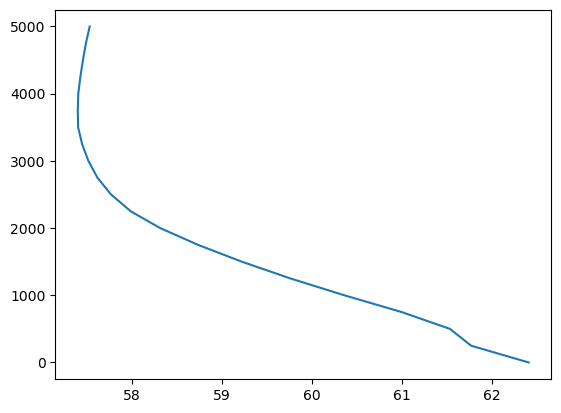

In [84]:
plt.plot(mean, ds.heightAboveGround)